In [ ]:
!git clone https://github.com/jakeret/unet

In [ ]:
!pip install ./unet/

In [104]:
import os
import pandas as pd
import unet
from unet import custom_objects
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import random
from tqdm import tqdm
from tensorflow.keras import backend as K

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = "/content/drive/MyDrive/Bakalaurinis/Final_code"
training_folder = os.path.join(path, "my_test_images/images")
df = pd.read_csv(os.path.join(path, "my_test_images/test.csv"))
healthy_df = df.query("label==4")
model_path = os.path.join(path, "models/UNet/UNetFinal")

In [6]:
unet_model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

In [7]:
def get_CIVE_band(img):
  img = cv2.GaussianBlur(img,(35,35),0)
  CIVE_band = 0.441*img[:,:,0] - 0.881*img[:,:,1] + 0.385*img[:,:,2] + 18.787
  normalized_CIVE_band = (((CIVE_band+abs(CIVE_band.min()))/CIVE_band.max())).astype(np.uint8)
  return normalized_CIVE_band

def apply_CIVE_mask(img, vegetation_index_band):
  ret, otsu = cv2.threshold(vegetation_index_band,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  masked_img = cv2.bitwise_and(img,img,mask = otsu)
  return masked_img

In [8]:
def get_image(img_path, target_size=512):
    img = Image.open(img_path)
    img = img.resize((target_size, target_size))
    img_height, img_width = img.size
    img = np.array(img)
    y = random.randint(0,np.maximum(img_height-target_size, 0))
    x = random.randint(0,np.maximum(img_width-target_size, 0))
    cropped_img = img[x:x+target_size , y:y+target_size,:]
    return cropped_img

1/1 [==============================] - 0s 20ms/step


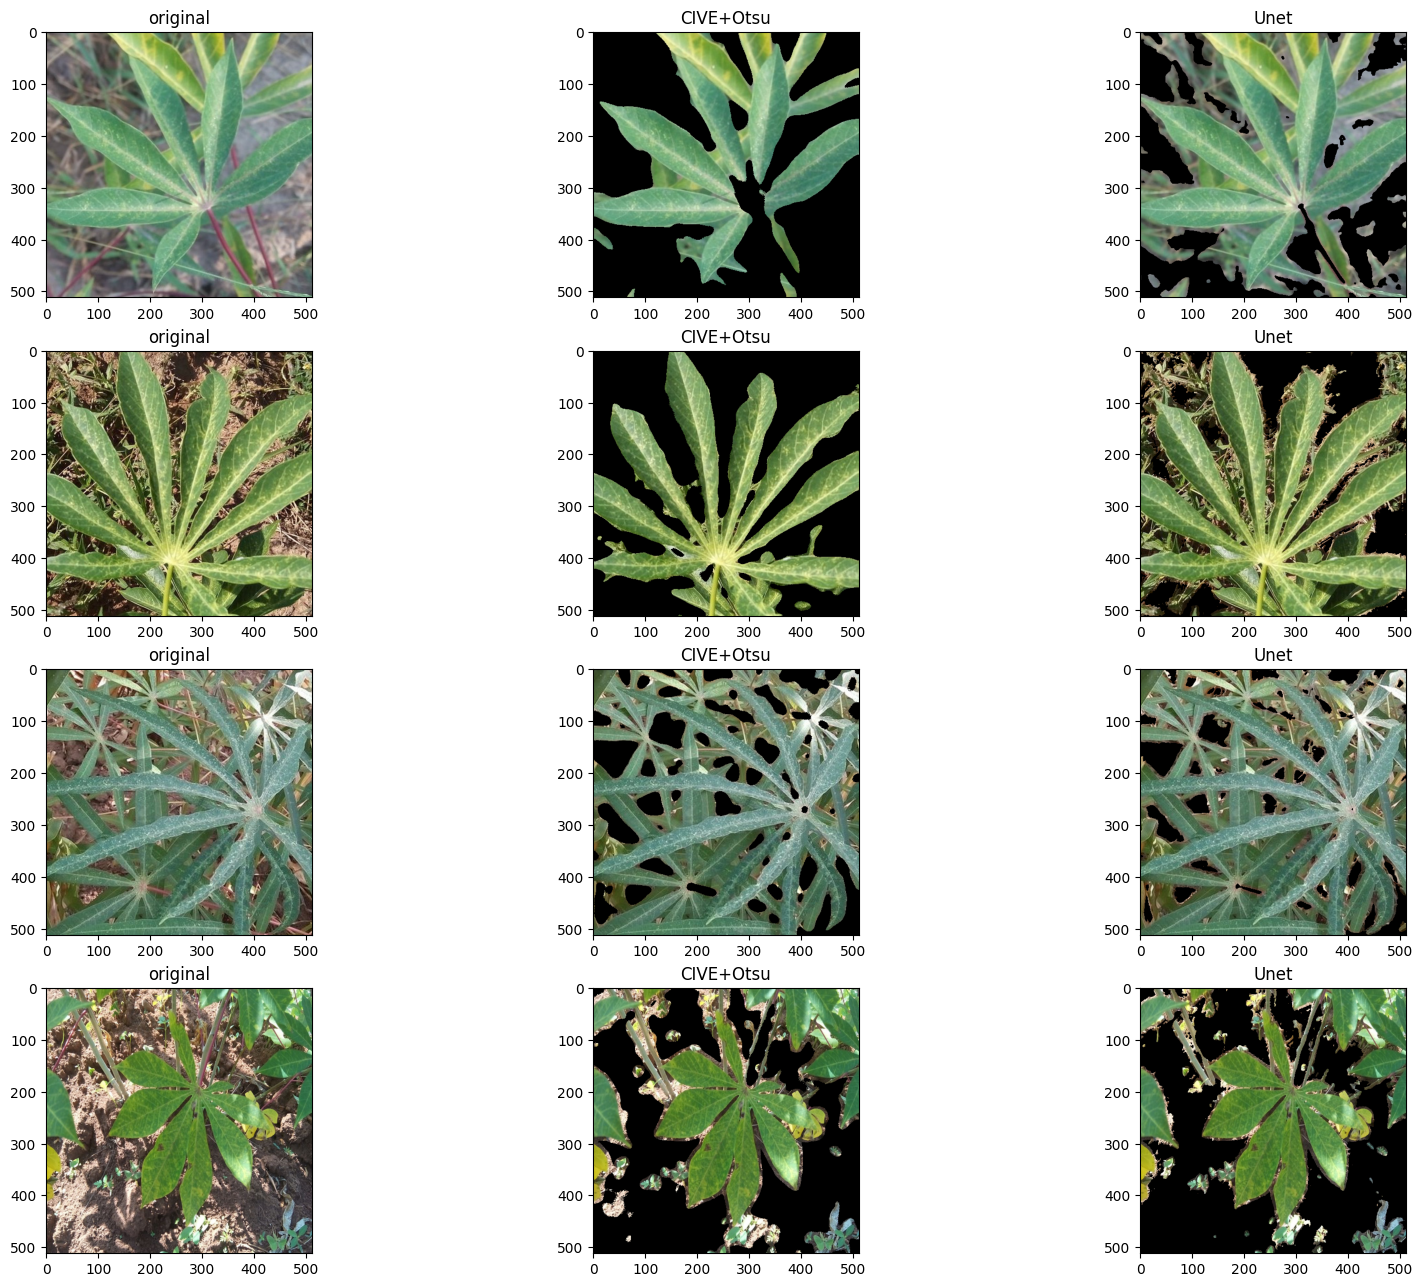

In [ ]:
plt.figure(figsize=(20, 20))
items = 5
for idx, image_id in enumerate(df.sample(n=4).image_id):
    img_path = os.path.join(training_folder, image_id)
    img = get_image(img_path)
    ax = plt.subplot(items, 3, idx*3 + 1)
    ax.set_title("original")
    plt.imshow(img)
    
    CIVE_band = get_CIVE_band(img)
    masked_img = apply_CIVE_mask(img, CIVE_band)
    ax = plt.subplot(items, 3, idx*3 + 2)
    ax.set_title("CIVE+Otsu")
    plt.imshow(masked_img)

    mask = unet_model.predict(np.array([img]))
    soil_mask = np.where(np.transpose(mask[0],(2,0,1))[0]<=0.5,1,0).astype(np.uint8)
    masked_img = cv2.bitwise_and(img,img,mask = soil_mask)
    ax = plt.subplot(items, 3, idx*3 + 3)
    ax.set_title("Unet")
    plt.imshow(masked_img)

In [9]:
def get_groundtruth_mask(img, target_size=512):
    img = cv2.GaussianBlur(img, (35, 35), 0)
    cive_band = 0.441 * img[:, :, 0] - 0.881 * img[:, :, 1] + 0.385 * img[:, :, 2] + 18.787
    normalized_cive_band = cv2.normalize(cive_band, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    _, otsu_mask = cv2.threshold(normalized_cive_band, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    masks = np.stack([otsu_mask == 0, otsu_mask == 255], axis=2).astype(np.uint8)
    return masks

In [10]:
images = [get_image(os.path.join(training_folder, path)) for path in tqdm(df.image_id)]
groundtruth = [get_groundtruth_mask(image) for image in tqdm(images)]

100%|██████████| 106/106 [00:01<00:00, 89.79it/s]


In [ ]:
predicted_masks = []
for image_id in tqdm(df.image_id):
    img_path = os.path.join(training_folder, image_id)
    img = get_image(img_path)
    mask = unet_model.predict(np.array([img]))[0]
    predicted_masks.append(mask)

In [34]:
predictionDf = df

In [36]:
predictionDf['groundtruth'] = groundtruth

In [38]:
predictionDf['prediction'] = predicted_masks

In [117]:
def segmentation_iou(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, dtype=tf.float32)
    y_pred = tf.cast(y_pred > 0.5, dtype=tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(tf.cast(y_true + y_pred > 0, dtype=tf.float32), axis=[1, 2])
    iou = intersection / union
    mean_iou = tf.reduce_mean(iou)
    return mean_iou

def binary_segmentation_dice(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, dtype=tf.float32)
    y_pred = tf.cast(y_pred > 0.5, dtype=tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum(y_pred) - tp
    fn = tf.reduce_sum(y_true) - tp
    dice_coeff = (2 * tp) / (2 * tp + fp + fn)
    return dice_coeff

def calculate_accuracy(y_true, y_pred):
    y_pred_binary = tf.cast(y_pred > 0.5, dtype=tf.float32)
    equality = tf.equal(y_true, y_pred_binary)
    accuracy = tf.reduce_mean(tf.cast(equality, tf.float32))
    return accuracy

In [118]:
iou_scores = []
dice_coefs = []
accuracies = []
for _, row in predictionDf.iterrows():
    ground_truth = row['groundtruth']
    prediction = row['prediction']
    iou = segmentation_iou(ground_truth, prediction).numpy()
    dice = binary_segmentation_dice(ground_truth, prediction).numpy()
    accuracy = calculate_accuracy(ground_truth, prediction).numpy()
    iou_scores.append(iou)
    dice_coefs.append(dice)
    accuracies.append(accuracy)
print(f'Vidutinis IoU: {sum(iou_scores) / len(iou_scores)}')
print(f'Vidutinis Dice coef: {sum(dice_coefs) / len(dice_coefs)}')
print(f'Vidutinis tikslumas: {sum(accuracies) / len(accuracies)}')

Vidutinis IoU: 0.6405583580709854
Vidutinis Dice coef: 0.7610491680086784
Vidutinis tikslumas: 0.7612138964095205
